## Odometry: Integration scheme comparison
This script compares two integration schemes, *Euler* and *RK2* (Runge-Kutta2) against exact integration of the kinematic model.

In [52]:
import numpy as np
import matplotlib.pyplot as plt

"""
Utility for plotting
"""
def draw_pose(ax, x, y, theta, radius=0.025, line_length=0.02, label=None):
    """
    Draw a pose as a circle with an orientation line.
    """
    # Circle
    circle = plt.Circle((x, y), radius, fill=False)
    ax.add_patch(circle)

    # Orientation line
    ax.plot(
        [x, x + line_length * np.cos(theta)],
        [y, y + line_length * np.sin(theta)]
    )

    if label is not None:
        ax.scatter(x, y, label=label)

"""
plot_unicycle_trajectory plots the pose of the unicycle
"""
def plot_unicycle_trajectory(x, y, theta, figsize=(6, 6), filename=None, dpi=300):
    fig, ax = plt.subplots(figsize=figsize)

    # Trajectory (x, y only)
    ax.plot(x, y, label="Trajectory")

    # Start and goal poses
    draw_pose(ax, x[0], y[0], theta[0], label="Start")
    draw_pose(ax, x[-1], y[-1], theta[-1], label="Goal")

    ax.set_xlim(-0.1,0.6)
    ax.set_ylim(-0.1,0.2)

    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()
    ax.grid(True)

    # Save figure if requested
    if filename is not None:
        fig.savefig(filename, dpi=dpi, bbox_inches="tight")

    plt.show()

We define the kinematic model for the unicycle:

$$\mathbf{\dot{q}}(\theta) = \begin{bmatrix}\dot{x} \\ \dot{y} \\ \dot{\theta} \end{bmatrix} = v \begin{bmatrix}c_{\theta} \\ s_{\theta} \\ 0 \end{bmatrix} + \dot{\theta} \begin{bmatrix}0 \\ 0 \\ 1 \end{bmatrix}$$

In [53]:
def unicycle_kin(v, do, q):
    return v * np.array([np.cos(q[2]), np.sin(q[2]), 0]) + do * np.array([0, 0, 1])

We define the *Euler* integration scheme:

$$\mathbf{q}_{k+1} = \mathbf{q}_k + dt\,\mathbf{\dot{q}}_k(\theta_k) $$

In [54]:
def Euler(q, dq, dt):
    return q + dt*dq

We define the *RK2* integration scheme:

$$\mathbf{q}_{k+1} = \mathbf{q}_k + dt\,\mathbf{\dot{q}}_k(\theta_k + \frac{dt\,\dot{\theta}_k}{2})$$

In [55]:
def RK2(v, do, q, dt):
    q_p = q + do*dt/2.
    dq_p = unicycle_kin(v, do, q_p)

    return q + dt * dq_p

We define the *exact* integration scheme:

$$\begin{bmatrix}x_{k+1} \\ y_{k+1} \\ \theta_{k+1}\end{bmatrix} = \begin{bmatrix}x_k + \frac{v_k}{\dot{\theta}_k}(s_{\theta_{k+1}} - s_{\theta_{k}}) \\ y_k - \frac{v_k}{\dot{\theta}_k}(c_{\theta_{k+1}} - c_{\theta_{k}}) \\ \theta_k+dt\,\dot{\theta}_k \end{bmatrix}$$

In [56]:
def exact(v, do, q, dt):
    q_next = q.copy()
    q_next[2] += do * dt

    dq = unicycle_kin(v, do, q)
    dq_next = unicycle_kin(v, do, q_next)
    
    q_next[0] = q[0] + (dq_next[1]-dq[1])/do
    q_next[1] = q[1] - (dq_next[0]-dq[0])/do
    return q_next

We start from $\mathbf{q}_0 = \mathbf{0}$ and we consider constant driving velocity $v$ and steer velocity $\dot{\theta}$.
To clearly see the differences among the various integration scheme we chose a large $dt = 0.1$.

In [62]:
q = np.array([0., 0., 0.]) # m, m, rad
v = 0.55 # m/sec
do = 0.5 # rad/sec
dt = 0.1 # sec

q_traj = []
q_traj.append(q)

## Euler

q: [0. 0. 0.]
q: [0.055 0.    0.05 ]
q: [0.10993126 0.00274885 0.1       ]
q: [0.16465649 0.00823969 0.15      ]
q: [0.2190389  0.01645879 0.2       ]
q: [0.27294256 0.0273856  0.25      ]
q: [0.32623275 0.04099282 0.3       ]
q: [0.37877625 0.05724643 0.35      ]
q: [0.43044175 0.07610581 0.4       ]
q: [0.48110011 0.09752382 0.45      ]
q: [0.5306247  0.12144692 0.5       ]


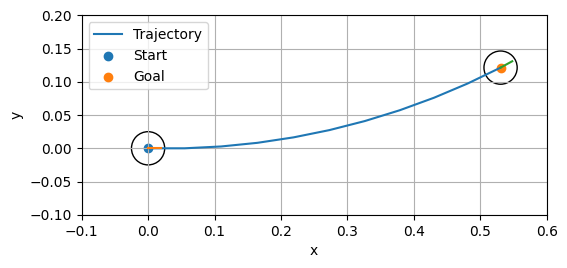

In [63]:
print(f"q: {q}") 
for i in range(10):
    dq = unicycle_kin(v, do, q)
    q = Euler(q, dq, dt)
    print(f"q: {q}") 
    q_traj.append(q)
q_traj = np.array(q_traj)
plot_unicycle_trajectory(q_traj[:,0], q_traj[:,1], q_traj[:,2], filename="Euler")

## RK2

q: [0. 0. 0.]
q: [0.05498281 0.00137486 0.05      ]
q: [0.1098282  0.00549599 0.1       ]
q: [0.16439907 0.0123531  0.15      ]
q: [0.21855903 0.02192905 0.2       ]
q: [0.27217271 0.0341999  0.25      ]
q: [0.32510609 0.04913498 0.3       ]
q: [0.37722688 0.06669696 0.35      ]
q: [0.4284048  0.08684195 0.4       ]
q: [0.47851193 0.1095196  0.45      ]
q: [0.52742303 0.13467321 0.5       ]


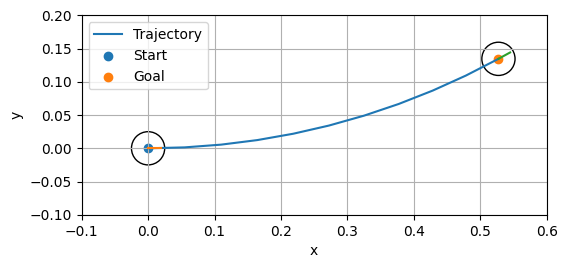

In [64]:
q = np.array([0., 0., 0.]) # m, m, rad
q_traj = []
q_traj.append(q)
print(f"q: {q}") 
for i in range(10):
    q = RK2(v, do, q, dt)
    print(f"q: {q}") 
    q_traj.append(q)
q_traj = np.array(q_traj)
plot_unicycle_trajectory(q_traj[:,0], q_traj[:,1], q_traj[:,2], filename="RK2")

## Exact

q: [0. 0. 0.]
q: [0.05497709 0.00137471 0.05      ]
q: [0.10981676 0.00549542 0.1       ]
q: [0.16438195 0.01235181 0.15      ]
q: [0.21853626 0.02192676 0.2       ]
q: [0.27214436 0.03419634 0.25      ]
q: [0.32507223 0.04912986 0.3       ]
q: [0.37718759 0.06669002 0.35      ]
q: [0.42836018 0.08683291 0.4       ]
q: [0.47846209 0.10950819 0.45      ]
q: [0.52736809 0.13465918 0.5       ]


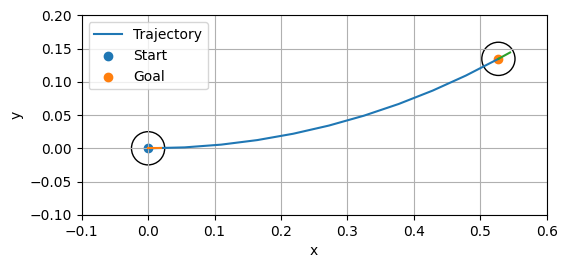

In [65]:
q = np.array([0., 0., 0.]) # m, m, rad
q_traj = []
q_traj.append(q)
print(f"q: {q}") 
for i in range(10):
    q = exact(v, do, q, dt)
    print(f"q: {q}") 
    q_traj.append(q)
q_traj = np.array(q_traj)
plot_unicycle_trajectory(q_traj[:,0], q_traj[:,1], q_traj[:,2], filename="exact")